In [22]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision


from model import AutoEncoder, LatentAutoEncoder
from utils import gif_interpolation, draw_reconstruction, random_interpolation

import imageio

In [24]:
EPOCH = 100
BATCH_SIZE = 100

In [25]:
train_data = torchvision.datasets.MNIST(
    root='datasets/mnist/',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=False,
)

In [26]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [27]:
latent_ae = LatentAutoEncoder(256, 'min-max', sigma=0.06).cuda()
latent_ae.set_device()
optimizer = torch.optim.Adam(latent_ae.parameters(), lr=0.001)
loss_func = nn.MSELoss()

In [10]:
for epoch in range(EPOCH):
    for step, (x, _) in enumerate(train_loader):
        optimizer.zero_grad()

        x_batch = x.view(-1, 28 * 28).cuda()
        y_batch = x.view(-1, 28 * 28).cuda()

        _, latent, transformed, decoded = latent_ae(x_batch)

        loss = loss_func(decoded, y_batch) 
        loss += torch.nn.functional.mse_loss(transformed, latent)
        loss.backward()
        optimizer.step()
        
    if epoch % 10 == 0: print('Epoch: ', epoch, '| train loss: %.4f' % loss.detach().cpu())

Epoch:  0 | train loss: 0.0573
Epoch:  10 | train loss: 0.0191
Epoch:  20 | train loss: 0.0118
Epoch:  30 | train loss: 0.0095
Epoch:  40 | train loss: 0.0075
Epoch:  50 | train loss: 0.0070
Epoch:  60 | train loss: 0.0066
Epoch:  70 | train loss: 0.0063
Epoch:  80 | train loss: 0.0063
Epoch:  90 | train loss: 0.0059


In [11]:
ae = AutoEncoder(256).cuda()
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)
loss_func = nn.MSELoss()

In [12]:
for epoch in range(10):
    for step, (x, _) in enumerate(train_loader):
        optimizer.zero_grad()
        
        x_batch = x.view(-1, 28 * 28).cuda()
        y_batch = x.view(-1, 28 * 28).cuda()
        
        _, decoded = ae(x_batch)

        loss = loss_func(decoded, y_batch) 
        loss.backward()
        optimizer.step()
        
    print('Epoch: ', epoch, '| train loss: %.4f' % loss.detach().cpu()) 

Epoch:  0 | train loss: 0.0274
Epoch:  1 | train loss: 0.0162
Epoch:  2 | train loss: 0.0105
Epoch:  3 | train loss: 0.0086
Epoch:  4 | train loss: 0.0077
Epoch:  5 | train loss: 0.0067
Epoch:  6 | train loss: 0.0060
Epoch:  7 | train loss: 0.0059
Epoch:  8 | train loss: 0.0053
Epoch:  9 | train loss: 0.0055


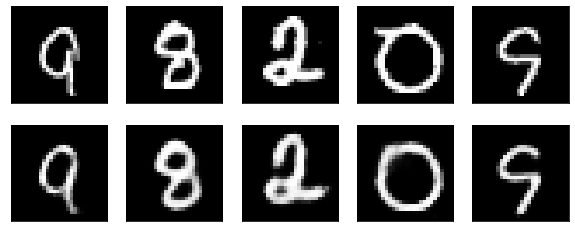

In [14]:
draw_reconstruction(ae, train_data, 5)

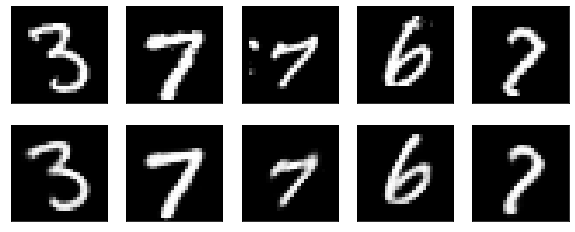

In [15]:
draw_reconstruction(latent_ae, train_data, 5)

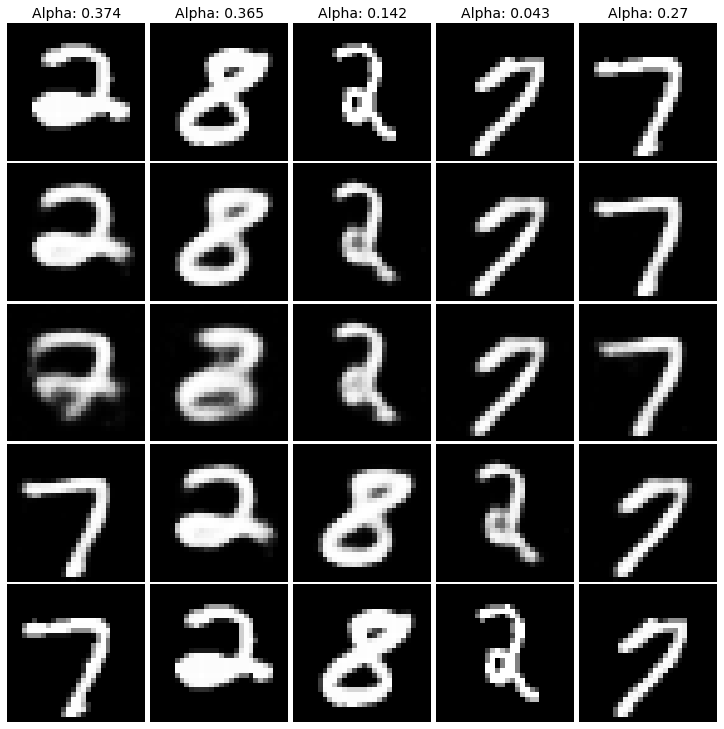

In [16]:
random_interpolation(ae, Data.DataLoader(dataset=train_data, batch_size=5, shuffle=True), False)

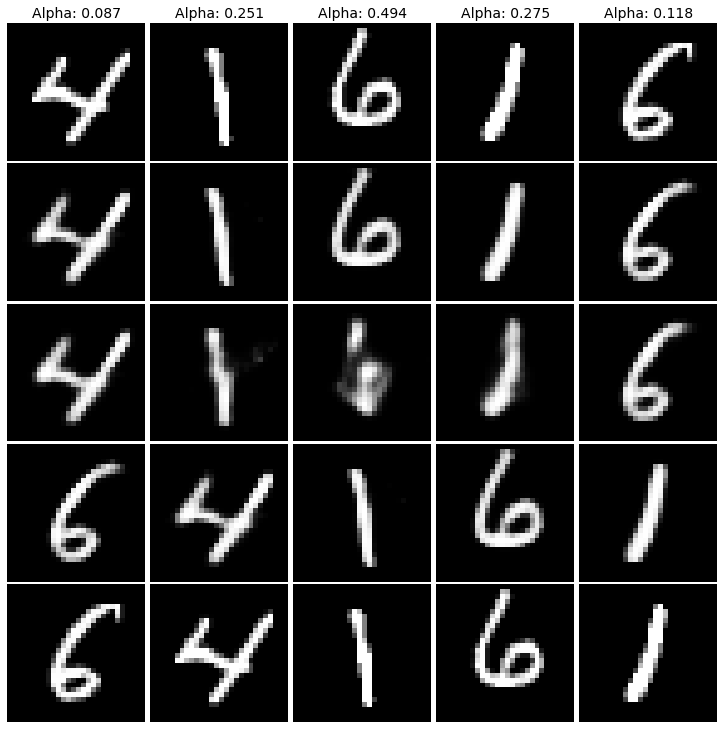

In [18]:
random_interpolation(latent_ae, Data.DataLoader(dataset=train_data, batch_size=5, shuffle=True))

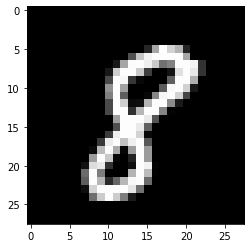

In [126]:
gif_interpolation(latent_ae, train_loader, 1, 8)

In [34]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

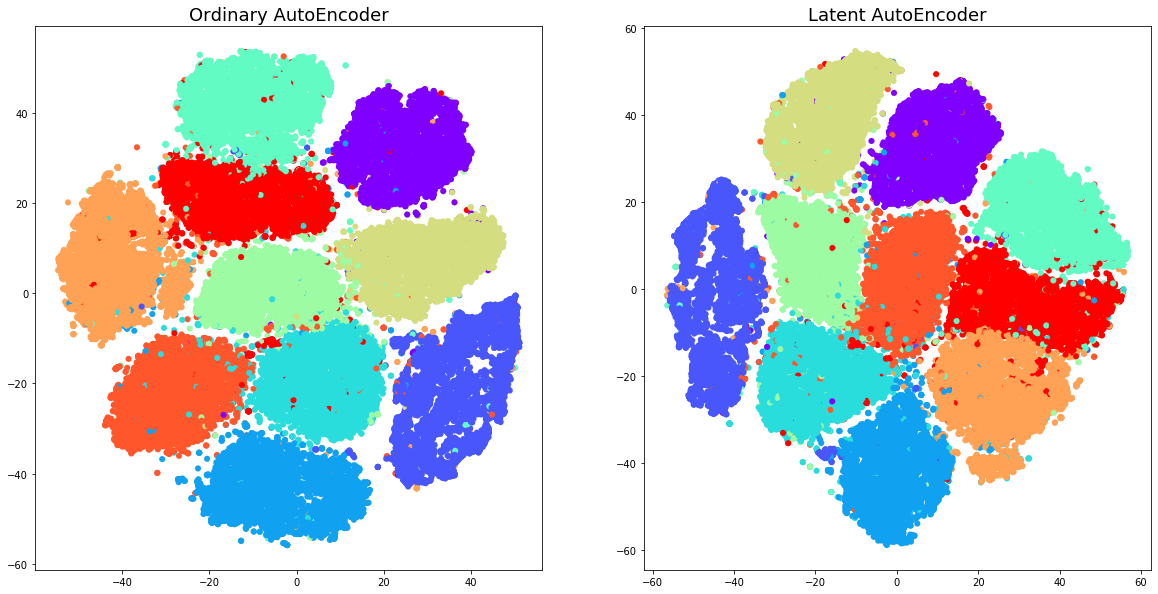

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

view_data = train_data.data.view(-1, 28 * 28).type(torch.FloatTensor) / 255.

encoded_data, _ = ae(view_data.cuda())
encoded = TSNE(2).fit_transform(encoded_data.detach().cpu().numpy())
ax[0].scatter(encoded[:, 0], encoded[:, 1], c=train_data.targets.numpy(), cmap='rainbow',  linewidths=0.1);
ax[0].set_title('Ordinary AutoEncoder', fontsize=18)

_, encoded_data, _, _ = latent_ae(view_data.cuda())
encoded = TSNE(2).fit_transform(encoded_data.detach().cpu().numpy())
ax[1].scatter(encoded[:, 0], encoded[:, 1], c=train_data.targets.numpy(), cmap='rainbow',  linewidths=0.1);
ax[1].set_title('Latent AutoEncoder', fontsize=18);

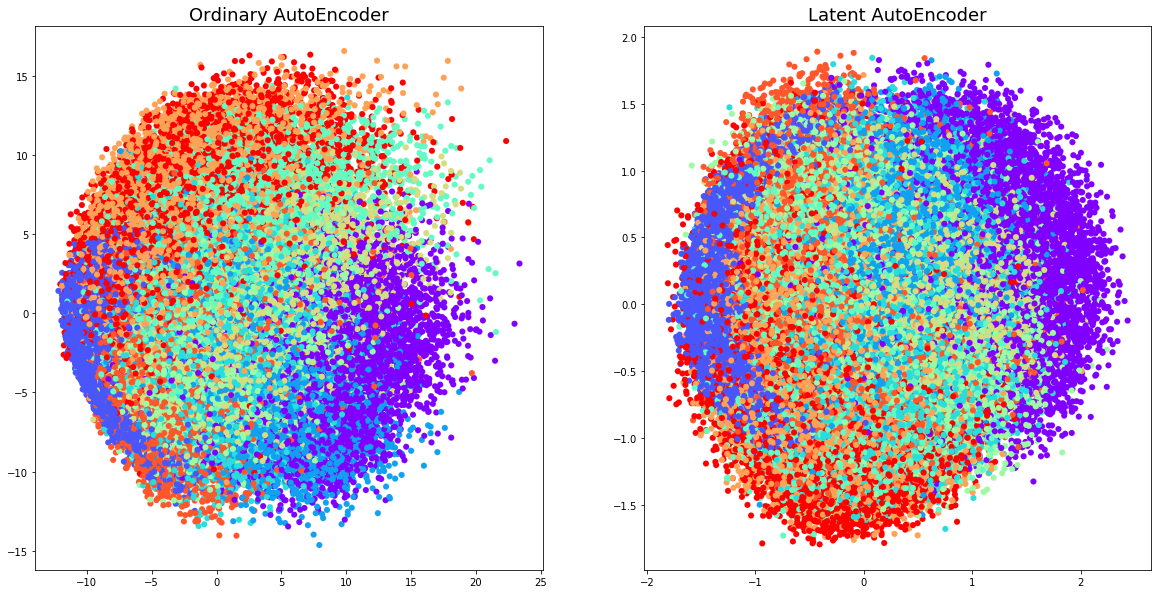

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

view_data = train_data.data.view(-1, 28 * 28).type(torch.FloatTensor) / 255.

encoded_data, _ = ae(view_data.cuda())
encoded = PCA(2).fit_transform(encoded_data.detach().cpu().numpy())
ax[0].scatter(encoded[:, 0], encoded[:, 1], c=train_data.targets.numpy(), cmap='rainbow',  linewidths=0.1);
ax[0].set_title('Ordinary AutoEncoder', fontsize=18)

_, encoded_data, _, _ = latent_ae(view_data.cuda())
encoded = PCA(2).fit_transform(encoded_data.detach().cpu().numpy())
ax[1].scatter(encoded[:, 0], encoded[:, 1], c=train_data.targets.numpy(), cmap='rainbow',  linewidths=0.1);
ax[1].set_title('Latent AutoEncoder', fontsize=18);

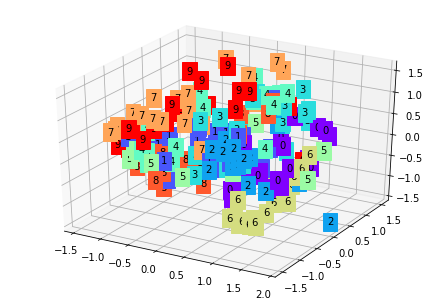

In [21]:
fig = plt.figure(2); ax = Axes3D(fig)
encoded = PCA(3).fit_transform(encoded_data[:200].detach().cpu().numpy())
X, Y, Z = encoded[:, 0], encoded[:, 1], encoded[:, 2]
values = train_data.targets[:200].numpy()
for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255 * s / 9)); ax.text(x, y, z, s, backgroundcolor=c)
ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
plt.show()